In [2]:
import ms_deisotope
from ms_deisotope.test.common import datafile

%matplotlib inline

from matplotlib import pyplot as plt, rcParams
rcParams['figure.figsize'] = 16, 4

# `ms_deisotope` Quickstart

This quickstart guide is designed to get you started using the high level APIs of `ms_deisotope` to process mass spectra.

We'll start by loading a test data file: *three_test_scans.mzML*, a simple mzML file with only one $\text{MS}$ scan and two $\text{MS}^n$ scans. The first step is to instantiate a reader. We can use `MSFileLoader` to automatically pick the right reader.

In [3]:
# We'll use the datafile helper to locate the package test data for demonstration purposes
path = datafile("three_test_scans.mzML")
reader = ms_deisotope.MSFileLoader(path)

Next, we'll fetch the next set of precursors and products using the `next()` method on the `reader`.

In [4]:
bunch = next(reader)
bunch

ScanBunch(
precursor=
Scan('controllerType=0 controllerNumber=1 scan=10014', index=0, time=22.1283, ms_level=1),
products=
[Scan('controllerType=0 controllerNumber=1 scan=10015', index=1, time=22.1328, ms_level=2, PrecursorInformation(mz=562.7397/0.0000, intensity=506701696.0000/0.0000, charge=2/0.0, scan_id='controllerType=0 controllerNumber=1 scan=10014')),
       Scan('controllerType=0 controllerNumber=1 scan=10016', index=2, time=22.1340, ms_level=2, PrecursorInformation(mz=617.2649/0.0000, intensity=3400959.2500/0.0000, charge=2/0.0, scan_id='controllerType=0 controllerNumber=1 scan=10014'))])

The precursor scan is in profile mode

In [5]:
bunch.precursor.is_profile

True

We can centroid the peaks using the `pick_peaks` method of the scan.

In [6]:
bunch.precursor.pick_peaks()
bunch.precursor.peak_set

PeakIndex(27826 points, 2108 peaks)

We can annotate the $\text{MS}^1$ scan areas where precursors are isolated

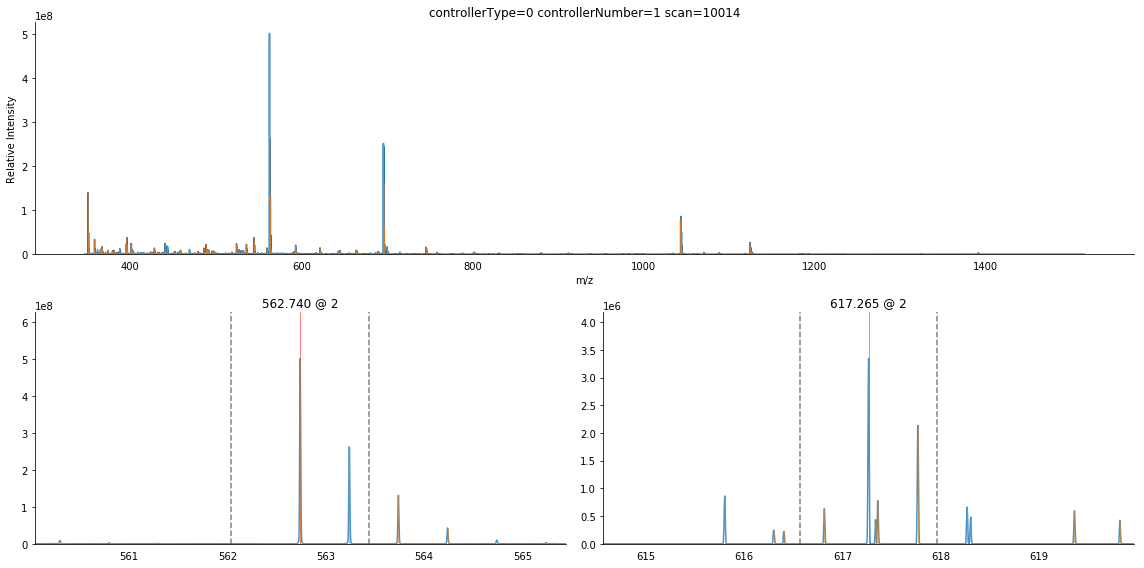

In [7]:
ax = bunch.annotate_precursors(nperrow=2)

We can count the number of peaks in the isolation window around the second precursor (617.265) to see how many peaks may be coisolated

In [8]:
window = bunch.products[1].isolation_window
bunch.precursor.peak_set.between(window.lower_bound, window.upper_bound)

<PeakSet 5 Peaks>

By eye, we can see there are five peaks, and the `between` query returns five peaks as well. That precursor is on the low end of the abundance scale, and it may be hard to recognize noise peaks. We can deconvolute the $\text{MS}$ scan to determine the charge and monoisotopic m/z for all peaks in the scan and this can help to discrminate peaks which may not be reliable.

In [9]:
bunch.precursor.deconvolute(averagine=ms_deisotope.peptide, scorer=ms_deisotope.MSDeconVFitter(10.))
bunch.precursor.deconvoluted_peak_set

<DeconvolutedPeakSet 1297 Peaks>

That reduced the number of peaks to consider from over 2,000 to just under 1,300.

In [10]:
bunch.precursor.deconvoluted_peak_set.between(window.lower_bound, window.upper_bound, use_mz=True)

<DeconvolutedPeakSet 2 Peaks>

This tells us there are only two isotopic patterns whose monoisotopic m/z falls in the isolation window.

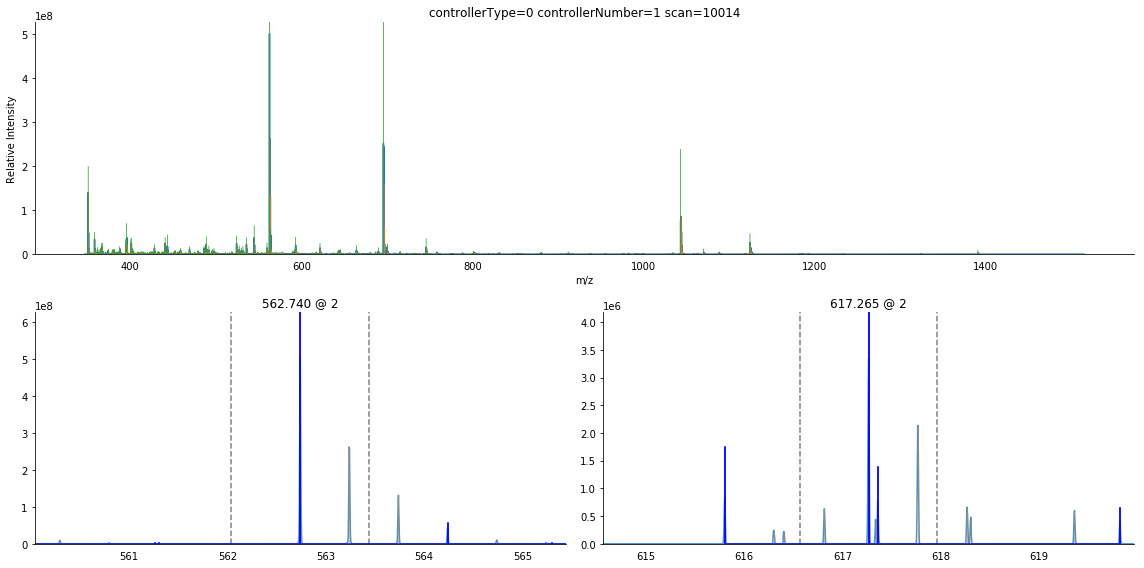

In [11]:
ax = bunch.annotate_precursors(nperrow=2)

The dark blue lines denote deisotoped peaks. We can see that there is a peak to the left of the isolation window whose isotopic envelope also overlaps it.

(Scan('controllerType=0 controllerNumber=1 scan=10015', index=1, time=22.1328, ms_level=2, PrecursorInformation(mz=562.7397/0.0000, intensity=506701696.0000/0.0000, charge=2/0.0, scan_id='controllerType=0 controllerNumber=1 scan=10014')),
 221)

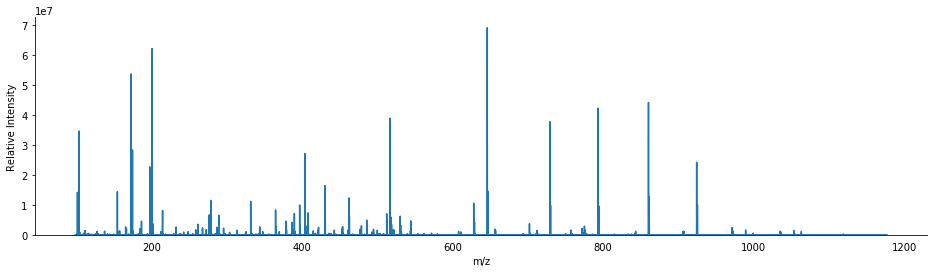

In [12]:
product = bunch.products[0]
product.pick_peaks()
product.arrays.plot()
product, len(product.peak_set)

(500, 550)

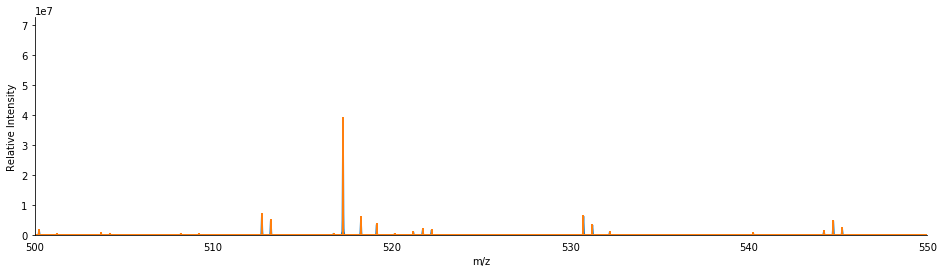

In [13]:
ax = product.arrays.plot()
ms_deisotope.utils.draw_peaklist(product.peak_set, ax=ax, lw=2)
ax.set_xlim(500, 550)

We can deisotope the product scan to remove the isotopic peaks and simplify the spectrum

In [35]:
product.deconvolute(averagine=ms_deisotope.peptide, scorer=ms_deisotope.MSDeconVFitter(10.),
                    max_missed_peaks=1, charge_range=(1, product.precursor_information.charge))
len(product.deconvoluted_peak_set)

152

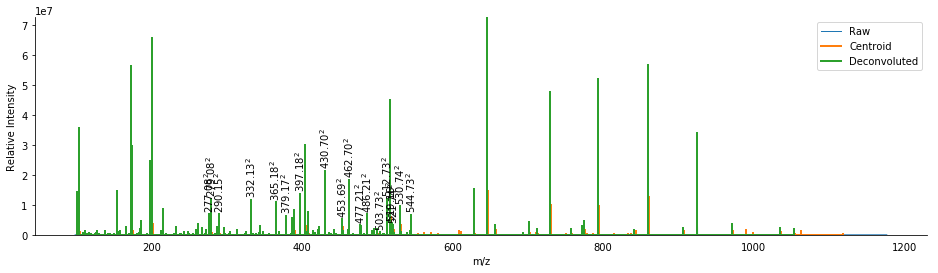

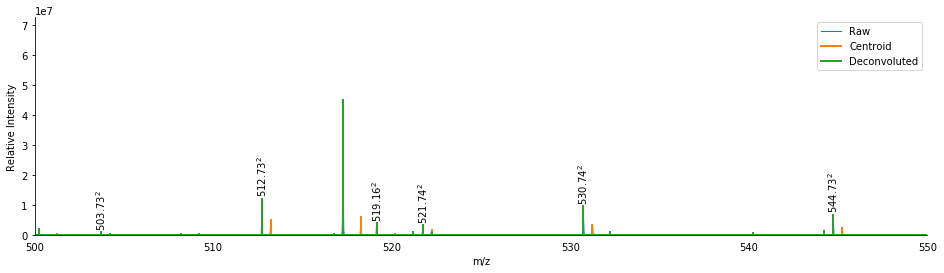

In [36]:
ax = product.arrays.plot(label='Raw', lw=1)
ms_deisotope.utils.draw_peaklist(product.peak_set, ax=ax, lw=2, label='Centroid')
ms_deisotope.utils.draw_peaklist(product.deconvoluted_peak_set, ax=ax, lw=2, label='Deconvoluted')
for peak in product.deconvoluted_peak_set:
    if peak.charge > 1:
        ax.text(peak.mz, peak.intensity + ax.get_ylim()[1] * 0.01,
                "$%0.2f^%d$" % (peak.mz, peak.charge), va='bottom', ha='center', rotation=90,
                clip_on=True)
ax.legend()
display(ax.figure)
_ = ax.set_xlim(500, 550)


This removed 69 isotopic peaks from the spectrum, including the abundant A+1 peaks from the higher m/z peaks in the spectrum. We also see several multiply-charged product ions. Some of these ions are small and low in abundance, so it might be beneficial to check which masses are present both singly and doubly charged.

We'll do this by querying the `deconvoluted_peak_set` attribute of `product` using `DeconvolutedPeakSet.all_peaks_for`.

In [37]:
seen = set()
for peak in product.deconvoluted_peak_set:
    if peak in seen:
        continue
    seen.add(peak)
    all_for = product.deconvoluted_peak_set.all_peaks_for(peak.neutral_mass)
    if len(all_for) > 1:
        all_for = sorted(all_for, key=lambda x: x.mz, reverse=1)
        print peak.neutral_mass
        print [(p.mz, p.charge, p.score) for p in all_for]
        for p in all_for:
            seen.add(p)


728.343623987
[(729.3512365140559, 1, 7641.586719903839), (365.17908846043434, 2, 3974.0392814118777)]
756.325933622
[(757.3375606274757, 1, 1229.4184357706297), (379.17024327784117, 2, 2993.183880791818)]
792.341521491
[(793.3487979573216, 1, 7112.189429899965), (397.1791384435298, 2, 4478.046582621094)]
859.384865896
[(860.3922369366855, 1, 8148.628541826695), (430.6997094145263, 2, 5154.952375827611)]
923.382506619
[(924.3897830858219, 1, 7188.717282372034), (462.69874701632676, 2, 5361.219818531934)]
970.414635624
[(971.4242097498669, 1, 2302.9869681779255), (486.214594278865, 2, 3073.0652030648903)]


We can use `DeconvolutedPeakSet.has_peak` or `DeconvolutedPeakSet.all_peaks_for` to search for peaks by neutral mass. `has_peak` will return the first peak to match a neutral mass within a parts-per-million mass error tolerance, while `all_peaks_for` will return all peaks within that same mass error tolerance.

If we have a more complex LC-MS/MS we need to deconvolute, we can use the `ScanProcessor` class to automate sequential deconvolution of precursor-product groups. This class also takes care of correcting precursor masses and other conveniences for deconvoluting only part of an LC-MS/MS run.

In [53]:
from ms_deisotope import ScanProcessor

We'll use an example glycopeptide dataset from an Agilent 6550 QTOF. This file has already been denoised and centroided

In [70]:
complex_mzml = datafile("20150710_3um_AGP_001_29_30.mzML.gz")

In [71]:
raw = ms_deisotope.MSFileLoader(complex_mzml)
raw_bunch = next(raw)

In [76]:
raw_bunch

ScanBunch(
precursor=
Scan('scanId=1739784', index=0, time=28.9963, ms_level=1),
products=
[Scan('scanId=1740086', index=1, time=29.0013, ms_level=2, PrecursorInformation(mz=1161.0110/0.0000, intensity=795342.7477/0.0000, charge=4/0.0, scan_id='scanId=1739784')),
       Scan('scanId=1740149', index=2, time=29.0024, ms_level=2, PrecursorInformation(mz=1198.0268/0.0000, intensity=134530.9754/0.0000, charge=4/0.0, scan_id='scanId=1739784')),
       Scan('scanId=1740226', index=3, time=29.0037, ms_level=2, PrecursorInformation(mz=929.0112/0.0000, intensity=723340.9692/0.0000, charge=5/0.0, scan_id='scanId=1739784')),
       Scan('scanId=1740344', index=4, time=29.0056, ms_level=2, PrecursorInformation(mz=1088.2372/0.0000, intensity=149797.8771/0.0000, charge=4/0.0, scan_id='scanId=1739784')),
       Scan('scanId=1740492', index=5, time=29.0081, ms_level=2, PrecursorInformation(mz=1002.0360/0.0000, intensity=286732.4126/0.0000, charge=5/0.0, scan_id='scanId=1739784'))])

In [75]:
raw_bunch.precursor.is_profile

False

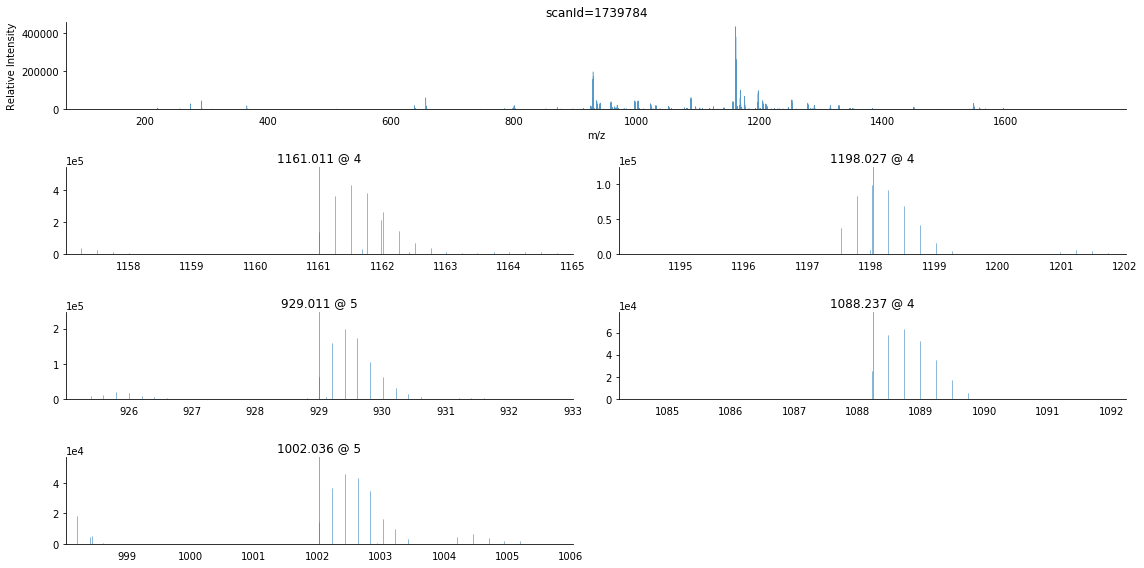

In [73]:
raw_bunch.annotate_precursors(2)

As you can see, this scan is more complex than the previous example, having more product ions and higher charge states. Furthermore, the eye can readily tell that the second precursor's reported m/z is not the monoisotopic peak.

Constructing a `ScanProcessor` instance is similar to creating a normal file reader, except in addition it takes several arguments which affect how $\text{MS}^1$ and $\text{MS}^n$ scans are centroided. As this file is already centroided, we'll just specify deconvolution arguments.

In [74]:
reader = ScanProcessor(complex_mzml, ms1_deconvolution_args={
    "averagine": ms_deisotope.glycopeptide,
    "scorer": ms_deisotope.PenalizedMSDeconVFitter(20., 2.)
}, msn_deconvolution_args={
    "averagine": ms_deisotope.peptide,
    "scorer": ms_deisotope.MSDeconVFitter(10.),
    "truncate_after": 0.8
})

The `ScanProcessor` type takes a `dict` describing the parameters passed to the `ms_deisotope.deconvolute_peaks` function which does the actual deconvoluting. These parameters control how the deconvolution process grades peaks against theoretical isotopic patterns (`scorer`), which theoretical isotopic model to use (`averagine`), and how much of the isotopic pattern to look for (`truncate_after`). The `MSDeconVFitter` and `PenalizedMSDeconVFitter` scorers are sensitive to intensity scale, so adjusting their threshold parameter may be helpful. See more in the documentation.

In [67]:
bunch = next(reader)

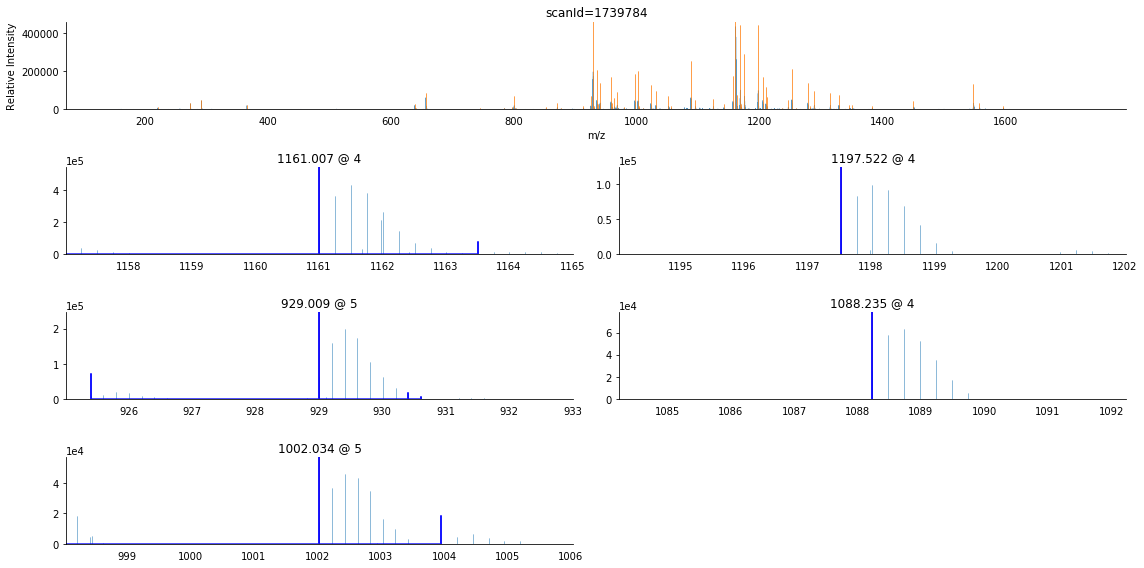

In [68]:
bunch.annotate_precursors(2)

In [69]:
bunch.products

[Scan('scanId=1740086', index=1, time=29.0013, ms_level=2, PrecursorInformation(mz=1161.0110/1161.0075, intensity=795342.7477/1804288.3125, charge=4/4, scan_id='scanId=1739784')),
 Scan('scanId=1740149', index=2, time=29.0024, ms_level=2, PrecursorInformation(mz=1198.0268/1197.5220, intensity=134530.9754/441541.9316, charge=4/4, scan_id='scanId=1739784')),
 Scan('scanId=1740226', index=3, time=29.0037, ms_level=2, PrecursorInformation(mz=929.0112/929.0089, intensity=723340.9692/793472.4805, charge=5/5, scan_id='scanId=1739784')),
 Scan('scanId=1740344', index=4, time=29.0056, ms_level=2, PrecursorInformation(mz=1088.2372/1088.2345, intensity=149797.8771/255720.2891, charge=4/4, scan_id='scanId=1739784')),
 Scan('scanId=1740492', index=5, time=29.0081, ms_level=2, PrecursorInformation(mz=1002.0360/1002.0339, intensity=286732.4126/201191.5088, charge=5/5, scan_id='scanId=1739784'))]

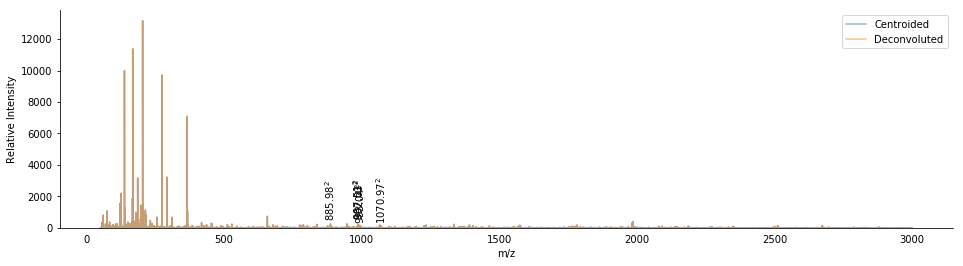

In [81]:
ax = ms_deisotope.utils.draw_peaklist(bunch.products[1].peak_set, alpha=0.5, label='Centroided')
ax = ms_deisotope.utils.draw_peaklist(bunch.products[1].peak_set, alpha=0.5, label='Deconvoluted', ax=ax)
for peak in bunch.products[1].deconvoluted_peak_set:
    if peak.charge > 1 and peak.mz > 400:
        ax.text(peak.mz, peak.intensity + ax.get_ylim()[1] * 0.01,
                "$%0.2f^%d$" % (peak.mz, peak.charge), va='bottom', ha='center', rotation=90,
                clip_on=True)
ax.legend()